In [1]:
import os

import jax
from matplotlib import pyplot as plt
import numpy as np
from scenic.projects.owl_vit import models
from scenic.projects.owl_vit.configs import clip_b32
from scipy.special import expit as sigmoid
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform

In [2]:
VQA_PATH='/Data_Storage/Rui_Data_Space/multimodal/VQA'
GQA_PATH='/Data_Storage/Rui_Data_Space/multimodal/GQA'

In [3]:
import pandas as pd
import json
import pickle as pkl
import numpy as np
import h5py
import random
from PIL import Image
import IPython.display as display
from collections import defaultdict

In [4]:
import matplotlib.pyplot as plt
import torch

In [5]:
def load_pkl(path):
    data=pkl.load(open(path,'rb'))
    return data

def load_json(path):
    data=json.load(open(path,'r'))
    return data

In [6]:
vqa_val=load_json(os.path.join(VQA_PATH,'scenes','val_all.json'))
print (len(vqa_val))

214354


In [7]:
val_counting=[]
for row in vqa_val:
    ans_type=row['ans_type']
    q_type=row['q_type']
    if ans_type=='number' and q_type=='how many':
        val_counting.append(row)
print (len(val_counting))

20320


In [8]:
idx2ent=load_pkl(os.path.join(VQA_PATH,'questions','val_idx2ent.pkl'))

In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

In [11]:
import inflect
stemmer = inflect.engine()

In [12]:
#how to filter out infrequent objects when doing prompting
#device = "cuda" if torch.cuda.is_available() else "cpu"

CUDA_DEVICE=5
torch.cuda.set_device(CUDA_DEVICE)
device = torch.device("cuda:"+str(CUDA_DEVICE))

In [6]:
from scenic.projects.owl_vit.configs import clip_l14
config = clip_l14.get_config()

In [7]:
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

In [8]:
variables = module.load_variables(config.init_from.checkpoint_path)

2022-08-13 08:37:24.720254: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [10]:
def get_tokens(text_queries):
    tokenized_queries = np.array([
        module.tokenize(q, config.dataset_configs.max_query_length)
        for q in text_queries
    ])
    # Pad tokenized queries to avoid recompilation if number of queries changes:
    tokenized_queries = np.pad(
        tokenized_queries,
        pad_width=((0, 100 - len(text_queries)), (0, 0)),
        constant_values=0)
    return tokenized_queries

In [11]:
def get_img_feat(img_id):
    # Load example image:
    filename = os.path.join(VQA_PATH,'images/val2014',img_id)
    image_uint8 = skimage_io.imread(filename)
    image = image_uint8.astype(np.float32) / 255.0

    # Pad to square with gray pixels on bottom and right:
    h, w, _ = image.shape
    size = max(h, w)
    image_padded = np.pad(
        image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

    # Resize to model input size:
    input_image = skimage.transform.resize(
        image_padded,
        (config.dataset_configs.input_size, config.dataset_configs.input_size),
        anti_aliasing=True)
    return input_image

In [36]:
text_queries =['person']
img_id='58157'
img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
tokenized_queries = np.array([
    module.tokenize(q, config.dataset_configs.max_query_length)
    for q in text_queries
])

# Pad tokenized queries to avoid recompilation if number of queries changes:
tokenized_queries = np.pad(
    tokenized_queries,
    pad_width=((0, 100 - len(text_queries)), (0, 0)),
    constant_values=0)

In [37]:
# Load example image:
filename = os.path.join(VQA_PATH,'images/val2014',img_id)
image_uint8 = skimage_io.imread(filename)
image = image_uint8.astype(np.float32) / 255.0

# Pad to square with gray pixels on bottom and right:
h, w, _ = image.shape
size = max(h, w)
image_padded = np.pad(
    image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

# Resize to model input size:
input_image = skimage.transform.resize(
    image_padded,
    (config.dataset_configs.input_size, config.dataset_configs.input_size),
    anti_aliasing=True)

In [38]:
# Note: The model expects a batch dimension.
predictions = module.apply(
    variables,
    input_image[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_map(lambda x: np.array(x[0]), predictions )

0.17466983 0 [0.03573639 0.42284855 0.04206835 0.16477288]
0.17240824 0 [0.08846115 0.42209142 0.04821286 0.16408895]
0.1723578 0 [0.3536432  0.41990998 0.05535137 0.14833939]
0.16897006 0 [0.4273486  0.41488165 0.0529644  0.11418576]
0.17683905 0 [0.48947853 0.42149225 0.0684798  0.13805836]
0.16639912 0 [0.38010132 0.41504744 0.03886579 0.11756115]
0.1662942 0 [0.616209   0.4400007  0.08163434 0.13424322]
0.16877571 0 [0.6777948  0.43872738 0.07763719 0.12726025]
0.1684335 0 [0.11486975 0.4269022  0.03659505 0.10387608]
0.15045439 0 [0.5581375  0.43850282 0.01918151 0.04213748]
0.15453257 0 [0.5808661  0.43550077 0.0164525  0.03341544]
0.15669397 0 [0.754244   0.4284855  0.08423378 0.21089053]
0.16020699 0 [0.93825114 0.42856133 0.01935855 0.05362383]
0.16743869 0 [0.9682036  0.43270448 0.02765379 0.04544785]
0.15168956 0 [0.8173067  0.44085827 0.0166611  0.03132023]
0.1523148 0 [0.86060077 0.4388753  0.01580273 0.03672266]
16


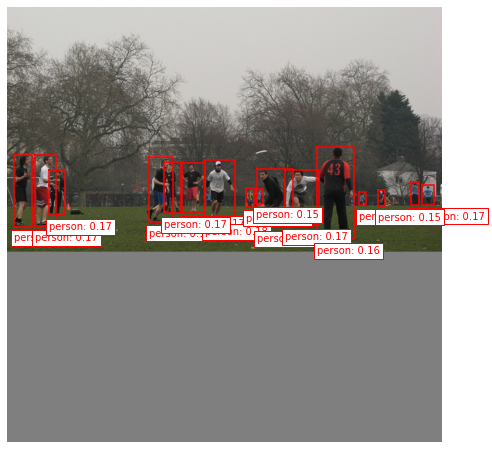

In [41]:
score_threshold = 0.15

logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
scores = sigmoid(np.max(logits, axis=-1))
labels = np.argmax(predictions['pred_logits'], axis=-1)
boxes = predictions['pred_boxes']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()
counter=0
for score, box, label in zip(scores, boxes, labels):
    if score < score_threshold:
        continue
    cx, cy, w, h = box
    ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
            [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
    print (score,label,box)
    ax.text(
        cx - w / 2,
        cy + h / 2 + 0.015,
        f'{text_queries[label]}: {score:1.2f}',
        ha='left',
        va='top',
        color='red',
        bbox={
            'facecolor': 'white',
            'edgecolor': 'red',
            'boxstyle': 'square,pad=.3'
        })
    counter+=1
print (counter)

In [ ]:
#analysis for the prediction

In [42]:
def plot_result(predictions, input_image,text_queries):
    score_threshold = 0.18
    logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
    scores = sigmoid(np.max(logits, axis=-1))
    labels = np.argmax(predictions['pred_logits'], axis=-1)
    boxes = predictions['pred_boxes']

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()
    counter=0
    for score, box, label in zip(scores, boxes, labels):
        #print (score,label)
        if score < score_threshold:
            continue
        cx, cy, w, h = box
        counter+=1
        ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
                [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
        ax.text(
            cx - w / 2,
            cy + h / 2 + 0.015,
            f'{text_queries[label]}: {score:1.2f}',
            ha='left',
            va='top',
            color='red',
            bbox={
                'facecolor': 'white',
                'edgecolor': 'red',
                'boxstyle': 'square,pad=.3'
            })
    return counter

In [44]:
def count_result(predictions, input_image,text_queries):
    score_threshold = 0.18
    logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
    scores = sigmoid(np.max(logits, axis=-1))
    labels = np.argmax(predictions['pred_logits'], axis=-1)
    boxes = predictions['pred_boxes']
    counter=0
    for score, box, label in zip(scores, boxes, labels):
        #print (score,label)
        if score < score_threshold:
            continue
        counter+=1
    return counter

	 0
COCO_val2014_000000254172.jpg animal
How many animals in this picture? ['4', '3'] [1, 0.3]
	 2
COCO_val2014_000000075405.jpg horse
How many horses are in the picture? ['2'] [1]
	 3
COCO_val2014_000000315790.jpg monitor
How many monitors? ['1'] [1]
	 4
COCO_val2014_000000572900.jpg pair
How many pairs of flip flops are in the picture? ['2'] [1]


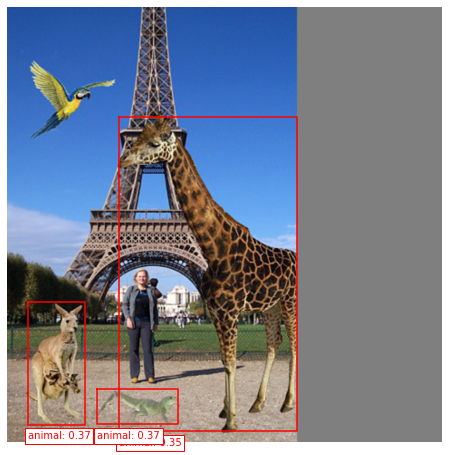

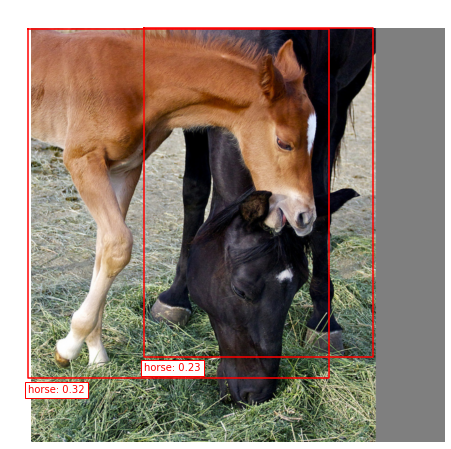

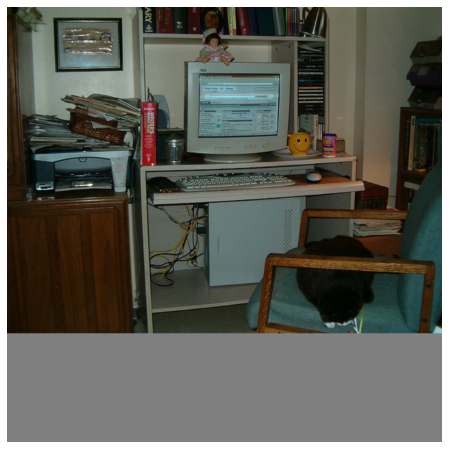

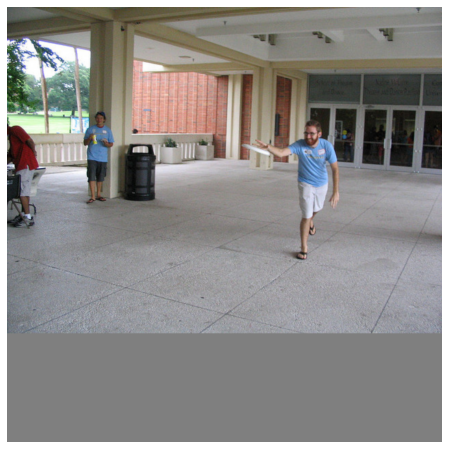

In [43]:
random.shuffle(val_counting)
for i in range(5):
    row=val_counting[i]
    ent=idx2ent[row['idx']]['ent']
    ent=stemmer.singular_noun(ent)
    if ent==False:
        continue
    #ent='bird'
    #ent='onion ring'
    ques=row['question']
    img_id=str(row['img_id'])
    img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
    answers=row['answer']
    gt_scores=row['scores']
    
    print ('\t',i)
    print (img_id,ent)
    print (ques,answers,gt_scores)
    
    tokenized_queries=get_tokens([ent])
    input_image=get_img_feat(img_id)
    predictions = module.apply(
        variables,
        input_image[None, ...],
        tokenized_queries[None, ...],
        train=False)

    # Remove batch dimension and convert to numpy:
    predictions = jax.tree_map(lambda x: np.array(x[0]), predictions )
    counter=plot_result(predictions,input_image,[ent])

In [ ]:
#random.shuffle(val_counting)
acc=0.0
no_findings=[]
total_val=0.0
for i,row in enumerate(val_counting):
    ent=idx2ent[row['idx']]['ent']
    ent=stemmer.singular_noun(ent)
    if ent==False:
        counter='many'
        if counter in answers:
            score=gt_scores[answers.index(counter)]
            acc+=score
        continue
    #ent='bird'
    #ent='onion ring'
    ques=row['question']
    img_id=str(row['img_id'])
    img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
    answers=row['answer']
    gt_scores=row['scores']
    
    tokenized_queries=get_tokens([ent])
    try:
        input_image=get_img_feat(img_id)
    except:
        print('Invalid image:',img_id)
        continue
        
    
    total_val+=1
    predictions = module.apply(
        variables,
        input_image[None, ...],
        tokenized_queries[None, ...],
        train=False)

    # Remove batch dimension and convert to numpy:
    predictions = jax.tree_map(lambda x: np.array(x[0]), predictions )
    counter=count_result(predictions,input_image,[ent])
    counter=str(counter)
    if counter=='0' and counter not in answers:
        no_findings.append(row['idx'])
    if counter in answers:
        score=gt_scores[answers.index(counter)]
        acc+=score
    if i%50==0:
        print ('\t',i)
        print (img_id,ent)
        print (ques,answers,gt_scores)
        print ('Current accuracy:',100.0*acc/total_val)
        print ('Prediction:',counter)

	 0
COCO_val2014_000000452113.jpg shoe
How many shoes  is there? ['24', '0'] [0.9, 1]
Current accuracy: 100.0
Prediction: 0
Invalid image: COCO_val2014_000000122051.jpg
	 50
COCO_val2014_000000090956.jpg marker
How many markers are in the photo? ['1', '2'] [1, 0.3]
Current accuracy: 22.5
Prediction: 0
	 100
COCO_val2014_000000250282.jpg female
How many females are sitting with the two men? ['7', 'many', '20', '10', '0'] [0.9, 0.9, 0.3, 0.3, 0.6]
Current accuracy: 35.56701030927835
Prediction: 0
Invalid image: COCO_val2014_000000039900.jpg
	 150
COCO_val2014_000000137538.jpg bird
How many birds? ['2'] [1]
Current accuracy: 39.45205479452054
Prediction: 2
	 200
COCO_val2014_000000285607.jpg bird
How many birds are seen in this photo? ['0'] [1]
Current accuracy: 40.721649484536066
Prediction: 0
	 250
COCO_val2014_000000033798.jpg person
How many people can fit on the couch? ['2', '3'] [1, 0.3]
Current accuracy: 41.893004115226326
Prediction: 0
	 300
COCO_val2014_000000036661.jpg picture
H

	 2700
COCO_val2014_000000265636.jpg sticker
How many stickers are there? ['13', '15', '3', '16'] [0.3, 1, 0.3, 0.3]
Current accuracy: 38.50363566781469
Prediction: 0
	 2750
COCO_val2014_000000276381.jpg bangle
How many bangles are on her left hand? ['2', '6', '10'] [1, 0.9, 0.3]
Current accuracy: 38.399699474079554
Prediction: 2
	 2800
COCO_val2014_000000577584.jpg teapot
How many teapots are there? ['0', '1'] [0.9, 1]
Current accuracy: 38.52713178294564
Prediction: 1
	 2850
COCO_val2014_000000015157.jpg letter
How many letters are on the sign? ['11', '4'] [1, 0.3]
Current accuracy: 38.27048585931824
Prediction: 4
	 2900
COCO_val2014_000000440045.jpg bench
How many benches are there? ['1'] [1]
Current accuracy: 38.61774136088339
Prediction: 1
	 2950
COCO_val2014_000000205101.jpg tater tot
How many tater tots? ['5'] [1]
Current accuracy: 38.589429471473444
Prediction: 5
	 3000
COCO_val2014_000000534194.jpg boat
How many boats are on the water? ['12', 'many', '7', '4', '10', '13', '8'] 

In [54]:
print (len(no_findings))
json.dump(no_findings,open(os.path.join(VQA_PATH,'questions/parser_no_finding.json'),'w'))

1782


In [55]:
opt_ent=load_pkl(os.path.join(VQA_PATH,'questions/ques_idx2ent_opt.pkl'))
print (len(opt_ent))

20320


In [56]:
#random.shuffle(val_counting)
acc=0.0
no_findings=[]
total_val=0.0
for i,row in enumerate(val_counting):
    ent=opt_ent[row['idx']]
    ent=stemmer.singular_noun(ent)
    if ent==False:
        counter='many'
        if counter in answers:
            score=gt_scores[answers.index(counter)]
            acc+=score
        continue
    #ent='bird'
    #ent='onion ring'
    ques=row['question']
    img_id=str(row['img_id'])
    img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
    answers=row['answer']
    gt_scores=row['scores']
    
    tokenized_queries=get_tokens([ent])
    try:
        input_image=get_img_feat(img_id)
    except:
        print('Invalid image:',img_id)
        continue
        
    
    total_val+=1
    predictions = module.apply(
        variables,
        input_image[None, ...],
        tokenized_queries[None, ...],
        train=False)

    # Remove batch dimension and convert to numpy:
    predictions = jax.tree_map(lambda x: np.array(x[0]), predictions )
    counter=count_result(predictions,input_image,[ent])
    counter=str(counter)
    if counter=='0' and counter not in answers:
        no_findings.append(row['idx'])
    if counter in answers:
        score=gt_scores[answers.index(counter)]
        acc+=score
    if i%50==0:
        print ('\t',i)
        print (img_id,ent)
        print (ques,answers,gt_scores)
        print ('Current accuracy:',100.0*acc/total_val)
        print ('Prediction:',counter)

	 0
COCO_val2014_000000452113.jpg shoe
How many shoes  is there? ['24', '0'] [0.9, 1]
Current accuracy: 100.0
Prediction: 0
Invalid image: COCO_val2014_000000122051.jpg
	 50
COCO_val2014_000000090956.jpg marker
How many markers are in the photo? ['1', '2'] [1, 0.3]
Current accuracy: 26.734693877551024
Prediction: 0
	 100
COCO_val2014_000000250282.jpg female
How many females are sitting with the two men? ['7', 'many', '20', '10', '0'] [0.9, 0.9, 0.3, 0.3, 0.6]
Current accuracy: 37.12765957446809
Prediction: 0
Invalid image: COCO_val2014_000000039900.jpg
	 150
COCO_val2014_000000137538.jpg bird
How many birds? ['2'] [1]
Current accuracy: 39.43661971830985
Prediction: 2
	 200
COCO_val2014_000000285607.jpg bird
How many birds are seen in this photo? ['0'] [1]
Current accuracy: 41.26984126984126
Prediction: 0
	 250
COCO_val2014_000000033798.jpg person
How many people can fit on the couch? ['2', '3'] [1, 0.3]
Current accuracy: 42.53164556962024
Prediction: 0
	 300
COCO_val2014_000000036661.j

	 2750
COCO_val2014_000000276381.jpg bangle
How many bangles are on her left hand? ['2', '6', '10'] [1, 0.9, 0.3]
Current accuracy: 39.36235204276433
Prediction: 2
	 2800
COCO_val2014_000000577584.jpg teapot
How many teapots are there? ['0', '1'] [0.9, 1]
Current accuracy: 39.42610652663156
Prediction: 1
	 2850
COCO_val2014_000000015157.jpg letter
How many letters are on the sign? ['11', '4'] [1, 0.3]
Current accuracy: 39.244935543277975
Prediction: 4
	 2900
COCO_val2014_000000440045.jpg bench
How many benches are there? ['1'] [1]
Current accuracy: 39.55845095910231
Prediction: 1
	 2950
COCO_val2014_000000205101.jpg tater tot
How many tater tots? ['5'] [1]
Current accuracy: 39.59089292066868
Prediction: 5
	 3000
COCO_val2014_000000534194.jpg boat
How many boats are on the water? ['12', 'many', '7', '4', '10', '13', '8'] [0.3, 0.3, 0.6, 0.3, 0.6, 0.3, 0.3]
Current accuracy: 39.538138558432344
Prediction: 6
	 3050
COCO_val2014_000000390685.jpg sign
How many signs total in this picture? [

	 5700
COCO_val2014_000000416308.jpg kite surfer
How many kite surfers are in the picture? ['1', '0', '22', 'unknown', 'lots', '50', '20'] [0.6, 0.3, 0.6, 0.3, 0.3, 0.3, 0.3]
Current accuracy: 39.262053735737744
Prediction: 0
	 5750
COCO_val2014_000000143483.jpg pillow
How many pillows are there? ['4', '9', '6', '8', '5', '7'] [0.9, 0.3, 0.3, 0.3, 0.9, 0.3]
Current accuracy: 39.29040496169263
Prediction: 7
	 5800
COCO_val2014_000000068715.jpg sign
How many signs are there? ['16', '17'] [1, 0.9]
Current accuracy: 39.328992584553994
Prediction: 0
	 5850
COCO_val2014_000000291144.jpg meter
How many meters are in the photo? ['2'] [1]
Current accuracy: 39.3059540889525
Prediction: 2
Invalid image: COCO_val2014_000000386204.jpg
	 5900
COCO_val2014_000000299649.jpg car
How many cars are parked near the runway? ['7', '0', '8'] [1, 0.3, 0.3]
Current accuracy: 39.281650071123615
Prediction: 0
	 5950
COCO_val2014_000000503707.jpg vehicle
How many vehicles are in the picture? ['4', '1'] [1, 0.3]
C

KeyboardInterrupt: 

In [57]:
print (len(no_findings))
json.dump(no_findings,open(os.path.join(VQA_PATH,'questions/opt_no_finding.json'),'w'))

2612
